In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')

## Import Ngl with pyn_env active 
import Ngl



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [3]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [4]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ_abs(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(np.abs(dvardz[iT,iLevs])==np.nanmax(np.abs(dvardz[iT,iLevs])))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [5]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values[0]/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values[0,:]
    hybm = DS.hybm.values[0,:]
    hyai = DS.hyai.values[0,:]
    hybi = DS.hybi.values[0,:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


## Get a suspicious day

In [6]:
## Where files are saved + start of casename
# dataDir = '/glade/scratch/mdfowler/CLASP_ensOutput/'
dataDir = '/glade/scratch/mdfowler/CLASP_ensOutput/multiplier/mult10_2017/'

htgFileStart = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

## Other settings to build up case names 
pertVals = np.asarray(['00'])


pertCount = 0
for iPert in range(len(pertVals)): 
    
    ## **** IMPORTANT: I've added the 2016 option to the listed files to look at just one year right now
    
    listFilesHTG_camh1 = np.sort(glob.glob(dataDir+htgFileStart+'*pert'+pertVals[iPert]+'*cam.h1*-07-*'))
    
    listFilesHTG_camh0 = np.sort(glob.glob(dataDir+htgFileStart+'*pert'+pertVals[iPert]+'*cam.h0*-07-*'))
    
    listFilesHTG_clmh0 = np.sort(glob.glob(dataDir+htgFileStart+'*pert'+pertVals[iPert]+'*clm2.h0.*-07-*'))
    
    fileCount=0
    for iFile in range(len(listFilesHTG_camh1)):
        with xr.open_dataset(listFilesHTG_camh1[iFile], decode_times=False) as htgDS: 
            htgDS         = cesm_correct_time(htgDS)
            htgDS['time'] = htgDS.indexes['time'].to_datetimeindex()

        with xr.open_dataset(listFilesHTG_clmh0[iFile], decode_times=True) as clm_htgDS: 
            clm_htgDS['time'] = htgDS['time']    
            
        
        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varHTG         = xr.open_dataset(listFilesHTG_camh0[iFile])[addVars[iVar]]
            varHTG['time'] = htgDS['time']

            htgDS = xr.merge([htgDS, varHTG])

        iTimeStart_day2  = np.where( (htgDS.time.values >= (htgDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                     (htgDS.time.values <= (htgDS.time.values[0] + np.timedelta64(2,'D'))))[0]
        iTimeStart_day3  = np.where( (htgDS.time.values >= (htgDS.time.values[0] + np.timedelta64(2,'D'))) & 
                                     (htgDS.time.values <= (htgDS.time.values[0] + np.timedelta64(3,'D'))))[0]
        

        # Build larger array 
        if fileCount==0:
            htg_allDay2      = htgDS.isel(time=iTimeStart_day2)
            htg_allDay3      = htgDS.isel(time=iTimeStart_day3)
            
            clmHTG_allDay2   = clm_htgDS.isel(time=iTimeStart_day2)
            clmHTG_allDay3   = clm_htgDS.isel(time=iTimeStart_day3)
            
        else: 
              
            htg_allDay2      = xr.concat([htg_allDay2,    htgDS.isel(time=iTimeStart_day2)],  dim='time')
            htg_allDay3      = xr.concat([htg_allDay3,    htgDS.isel(time=iTimeStart_day3)],  dim='time')

            clmHTG_allDay2   = xr.concat([clmHTG_allDay2, clm_htgDS.isel(time=iTimeStart_day2)], dim='time', data_vars='minimal')
            clmHTG_allDay3   = xr.concat([clmHTG_allDay3, clm_htgDS.isel(time=iTimeStart_day3)], dim='time', data_vars='minimal')
            
        fileCount = fileCount+1
        print('Done with day %i of %i ' % (iFile, len(listFilesHTG_camh1)) )
            
    ## Combine into larger HTG or HMG arrays for all pertlim experiments 
    
    htg_allDay2  = htg_allDay2.assign_coords({"pertlim": iPert})
    htg_allDay3  = htg_allDay3.assign_coords({"pertlim": iPert})

    clmHTG_allDay2 = clmHTG_allDay2.assign_coords({"pertlim": iPert})
    clmHTG_allDay3 = clmHTG_allDay3.assign_coords({"pertlim": iPert})

  

    if pertCount==0: 

        htgDS_pertDay2 = htg_allDay2
        htgDS_pertDay3 = htg_allDay3
        
        clm_htgDS_pertDay2 = clmHTG_allDay2
        clm_htgDS_pertDay3 = clmHTG_allDay3

        
        
 
    else: 
 
        htgDS_pertDay2 = xr.concat([htgDS_pertDay2, htg_allDay2], "pertlim")
        htgDS_pertDay3 = xr.concat([htgDS_pertDay3, htg_allDay3], "pertlim")

        clm_htgDS_pertDay2 = xr.concat([clm_htgDS_pertDay2, clmHTG_allDay2], "pertlim")
        clm_htgDS_pertDay3 = xr.concat([clm_htgDS_pertDay3, clmHTG_allDay3], "pertlim")

#     del hmg_allDay1
#     del hmg_allDay2
#     del hmg_allDay3
#     del hmg_allDay4
#     del hmg_allDay5
#     del hmg_allDay6
    
#     del htg_allDay1
#     del htg_allDay2
#     del htg_allDay3
#     del htg_allDay4
#     del htg_allDay5
#     del htg_allDay6    

    
    print('Done with pertlim ', pertCount)
    
    pertCount=pertCount+1
            

Done with day 0 of 33 
Done with day 1 of 33 
Done with day 2 of 33 
Done with day 3 of 33 
Done with day 4 of 33 
Done with day 5 of 33 
Done with day 6 of 33 
Done with day 7 of 33 
Done with day 8 of 33 
Done with day 9 of 33 
Done with day 10 of 33 
Done with day 11 of 33 
Done with day 12 of 33 
Done with day 13 of 33 
Done with day 14 of 33 
Done with day 15 of 33 
Done with day 16 of 33 
Done with day 17 of 33 
Done with day 18 of 33 
Done with day 19 of 33 
Done with day 20 of 33 
Done with day 21 of 33 
Done with day 22 of 33 
Done with day 23 of 33 
Done with day 24 of 33 
Done with day 25 of 33 
Done with day 26 of 33 
Done with day 27 of 33 
Done with day 28 of 33 
Done with day 29 of 33 
Done with day 30 of 33 
Done with day 31 of 33 
Done with day 32 of 33 
Done with pertlim  0


In [7]:
htgDS_pertDay2_mult10 = htgDS_pertDay2.copy(deep=True)
htgDS_pertDay3_mult10 = htgDS_pertDay3.copy(deep=True)


In [8]:
## Where files are saved + start of casename
# dataDir = '/glade/scratch/mdfowler/CLASP_ensOutput/'
dataDir = '/glade/scratch/mdfowler/CLASP_ensOutput/multiplier/mult5_2017/'

htgFileStart = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

## Other settings to build up case names 
pertVals = np.asarray(['00'])


pertCount = 0
for iPert in range(len(pertVals)): 
        
    listFilesHTG_camh1 = np.sort(glob.glob(dataDir+htgFileStart+'*pert'+pertVals[iPert]+'*cam.h1*-07-*'))
    
    listFilesHTG_camh0 = np.sort(glob.glob(dataDir+htgFileStart+'*pert'+pertVals[iPert]+'*cam.h0*-07-*'))
    
    listFilesHTG_clmh0 = np.sort(glob.glob(dataDir+htgFileStart+'*pert'+pertVals[iPert]+'*clm2.h0.*-07-*'))
    
    fileCount=0
    for iFile in range(len(listFilesHTG_camh1)):
        with xr.open_dataset(listFilesHTG_camh1[iFile], decode_times=False) as htgDS: 
            htgDS         = cesm_correct_time(htgDS)
            htgDS['time'] = htgDS.indexes['time'].to_datetimeindex()

        with xr.open_dataset(listFilesHTG_clmh0[iFile], decode_times=True) as clm_htgDS: 
            clm_htgDS['time'] = htgDS['time']    
            
        
        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varHTG         = xr.open_dataset(listFilesHTG_camh0[iFile])[addVars[iVar]]
            varHTG['time'] = htgDS['time']

            htgDS = xr.merge([htgDS, varHTG])

        iTimeStart_day2  = np.where( (htgDS.time.values >= (htgDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                     (htgDS.time.values <= (htgDS.time.values[0] + np.timedelta64(2,'D'))))[0]
        iTimeStart_day3  = np.where( (htgDS.time.values >= (htgDS.time.values[0] + np.timedelta64(2,'D'))) & 
                                     (htgDS.time.values <= (htgDS.time.values[0] + np.timedelta64(3,'D'))))[0]
        

        # Build larger array 
        if fileCount==0:
            htg_allDay2      = htgDS.isel(time=iTimeStart_day2)
            htg_allDay3      = htgDS.isel(time=iTimeStart_day3)
            
            clmHTG_allDay2   = clm_htgDS.isel(time=iTimeStart_day2)
            clmHTG_allDay3   = clm_htgDS.isel(time=iTimeStart_day3)
            
        else: 
              
            htg_allDay2      = xr.concat([htg_allDay2,    htgDS.isel(time=iTimeStart_day2)],  dim='time')
            htg_allDay3      = xr.concat([htg_allDay3,    htgDS.isel(time=iTimeStart_day3)],  dim='time')

            clmHTG_allDay2   = xr.concat([clmHTG_allDay2, clm_htgDS.isel(time=iTimeStart_day2)], dim='time', data_vars='minimal')
            clmHTG_allDay3   = xr.concat([clmHTG_allDay3, clm_htgDS.isel(time=iTimeStart_day3)], dim='time', data_vars='minimal')
            
        fileCount = fileCount+1
        print('Done with day %i of %i ' % (iFile, len(listFilesHTG_camh1)) )
            
    ## Combine into larger HTG or HMG arrays for all pertlim experiments 
    
    htg_allDay2  = htg_allDay2.assign_coords({"pertlim": iPert})
    htg_allDay3  = htg_allDay3.assign_coords({"pertlim": iPert})

    clmHTG_allDay2 = clmHTG_allDay2.assign_coords({"pertlim": iPert})
    clmHTG_allDay3 = clmHTG_allDay3.assign_coords({"pertlim": iPert})

  

    if pertCount==0: 

        htgDS_pertDay2 = htg_allDay2
        htgDS_pertDay3 = htg_allDay3
        
        clm_htgDS_pertDay2 = clmHTG_allDay2
        clm_htgDS_pertDay3 = clmHTG_allDay3

        
        
 
    else: 
 
        htgDS_pertDay2 = xr.concat([htgDS_pertDay2, htg_allDay2], "pertlim")
        htgDS_pertDay3 = xr.concat([htgDS_pertDay3, htg_allDay3], "pertlim")

        clm_htgDS_pertDay2 = xr.concat([clm_htgDS_pertDay2, clmHTG_allDay2], "pertlim")
        clm_htgDS_pertDay3 = xr.concat([clm_htgDS_pertDay3, clmHTG_allDay3], "pertlim")

    
    print('Done with pertlim ', pertCount)
    
    pertCount=pertCount+1
            

Done with day 0 of 33 
Done with day 1 of 33 
Done with day 2 of 33 
Done with day 3 of 33 
Done with day 4 of 33 
Done with day 5 of 33 
Done with day 6 of 33 
Done with day 7 of 33 
Done with day 8 of 33 
Done with day 9 of 33 
Done with day 10 of 33 
Done with day 11 of 33 
Done with day 12 of 33 
Done with day 13 of 33 
Done with day 14 of 33 
Done with day 15 of 33 
Done with day 16 of 33 
Done with day 17 of 33 
Done with day 18 of 33 
Done with day 19 of 33 
Done with day 20 of 33 
Done with day 21 of 33 
Done with day 22 of 33 
Done with day 23 of 33 
Done with day 24 of 33 
Done with day 25 of 33 
Done with day 26 of 33 
Done with day 27 of 33 
Done with day 28 of 33 
Done with day 29 of 33 
Done with day 30 of 33 
Done with day 31 of 33 
Done with day 32 of 33 
Done with pertlim  0


In [9]:
htgDS_pertDay2_mult05 = htgDS_pertDay2.copy(deep=True)
htgDS_pertDay3_mult05 = htgDS_pertDay3.copy(deep=True)


In [10]:
## Convert to local times...
# - - - - - - - - - - - - - - 
htgDS_pertDay2_mult05_local     = htgDS_pertDay2_mult05.copy(deep=True)
htgDS_pertDay3_mult05_local     = htgDS_pertDay3_mult05.copy(deep=True)

htgDS_pertDay2_mult10_local     = htgDS_pertDay2_mult10.copy(deep=True)
htgDS_pertDay3_mult10_local     = htgDS_pertDay3_mult10.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes_day2 = htgDS_pertDay2_mult10['time'].values - np.timedelta64(5,'h')
localTimes_day3 = htgDS_pertDay3_mult10['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
htgDS_pertDay2_mult05_local = htgDS_pertDay2_mult05_local.assign_coords({"time": localTimes_day2})
htgDS_pertDay3_mult05_local = htgDS_pertDay3_mult05_local.assign_coords({"time": localTimes_day3})

htgDS_pertDay2_mult10_local = htgDS_pertDay2_mult10_local.assign_coords({"time": localTimes_day2})
htgDS_pertDay3_mult10_local = htgDS_pertDay3_mult10_local.assign_coords({"time": localTimes_day3})



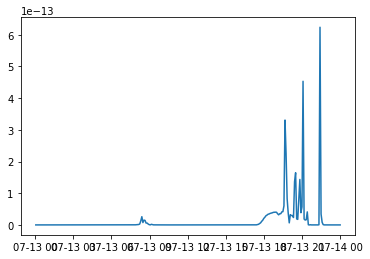

In [32]:
fig,axs = plt.
plt.plot(htgDS_pertDay2_mult05_local.time.values, np.squeeze(htgDS_pertDay2_mult05_local.PRECT.values))

## Dig into PBL calculation 

In [11]:
# # Convert HMGcamDS_all to height (nabbed from Rich's script)
# p0 = DS['P0'].values[0]

# plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
# plevm.attrs['units'] = "Pa"

# # Height with standard atmosphere
# zlevm      = plevm
# zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
# zlevm      = plevm.copy(deep=True)
# zlevm[:,:] = zlevm_vals

# pvar        = DS[pbl_var].isel(lat=0,lon=0)
# pvar['lev'] = zlevm[0,:].values
# dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

# dvardz.loc[:,200:]   = 0.  # Restrict to a specific height region
# dvardz.loc[:,:3000.] = 0

# nT = np.shape(dvardz)[0]
# PBLdepth = np.full([nT], np.nan)

# for iT in range(nT):
#     iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
#     maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
#     PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]


NameError: name 'DS' is not defined

In [13]:
selDay = np.where( (htgDS_pertDay2_mult10_local['time.day'].values==13) & (htgDS_pertDay2_mult10_local['time.month'].values==7) )[0]

htgDS_pertDay2_mult10_local = htgDS_pertDay2_mult10_local.isel(time=selDay)


In [14]:
selDay = np.where( (htgDS_pertDay2_mult05_local['time.day'].values==13) & (htgDS_pertDay2_mult05_local['time.month'].values==7) )[0]

htgDS_pertDay2_mult05_local = htgDS_pertDay2_mult05_local.isel(time=selDay)


In [136]:
# ## Resample to 30m ? 
# htgDS_pertDay2_mult05_local = htgDS_pertDay2_mult05_local.resample(time="30Min").mean()
# htgDS_pertDay3_mult05_local = htgDS_pertDay3_mult05_local.resample(time="30Min").mean()

# htgDS_pertDay2_mult10_local = htgDS_pertDay2_mult10_local.resample(time="30Min").mean()
# htgDS_pertDay3_mult10_local = htgDS_pertDay3_mult10_local.resample(time="30Min").mean()

In [29]:
p0 = htgDS_pertDay2_mult10_local.P0.values[0]

plevm10 = htgDS_pertDay2_mult10_local['hyam']*p0 + htgDS_pertDay2_mult10_local['hybm']*htgDS_pertDay2_mult10_local['PS'].isel(lat=0,lon=0) # Mid level
plevm10.attrs['units'] = "Pa"

# Get *potential* temperature, not just T 
theta = np.asarray(mpc.potential_temperature(plevm10 * units.pascals, htgDS_pertDay2_mult10_local['T'] * units.kelvin))
# Add to existing DS
htgDS_pertDay2_mult10_local['theta'] = (('time','lev','lat','lon'), theta)

# Height with standard atmosphere
zlevm10      = plevm10
zlevm10_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm10)) # Units of [m] after multiplied 
zlevm10      = plevm10.copy(deep=True)
zlevm10[:,:] = zlevm10_vals


pvar10        = htgDS_pertDay2_mult10_local['theta'].isel(lat=0,lon=0)
pvar10['lev'] = zlevm10[0,:].values
dvardz10      = pvar10.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz10.loc[:,200:]   = 0.  # Restrict to a specific height region
dvardz10.loc[:,:3000.] = 0

nT         = np.shape(dvardz10)[0]
PBLdepth10 = np.full([nT], np.nan)

for iT in range(nT):
    iLevs  = np.where((zlevm10[iT,:]>=200) & (zlevm10[iT,:]<=4000))[0]
    maxLev = np.where(np.abs(dvardz10[iT,iLevs])==np.nanmax(np.abs(dvardz10[iT,iLevs])))[0]
    PBLdepth10[iT] = zlevm10[iT,iLevs[maxLev[0]]]



Text(0.5, 1.0, '7/13/17 (Mult10; day2)')

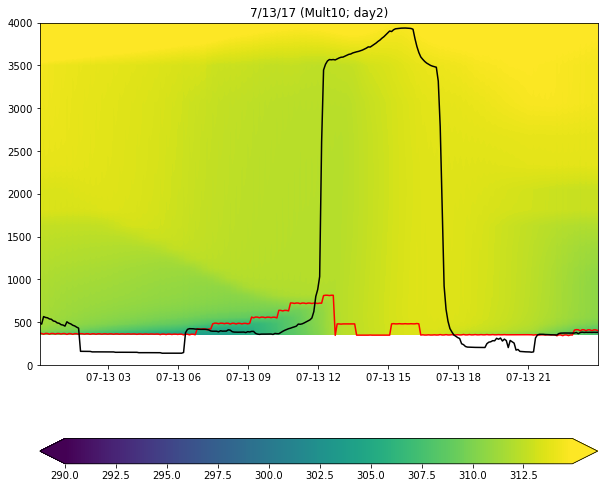

In [30]:
fig,axs = plt.subplots(1,1, figsize=(10,9) )

cplot = axs.contourf(htgDS_pertDay2_mult10_local.time.values, 
                     # htgDS_pertDay2_mult10_local.lev.values, 
                     zlevm10.mean(dim='time'),
                     np.squeeze(htgDS_pertDay2_mult10_local.theta.values).transpose(),
                     levels=np.arange(290,315,0.1),
                     cmap='viridis',extend='both'
                     )

# axs2 = axs.twinx()
axs.plot(htgDS_pertDay2_mult10_local.time.values,PBLdepth10,'r-')
axs.plot(htgDS_pertDay2_mult10_local.time.values, np.squeeze(htgDS_pertDay2_mult10_local.PBLH.values),'k-')

# axs.invert_yaxis()
axs.set_ylim([0,4000])
fig.colorbar(cplot, orientation='horizontal')
axs.set_title('7/13/17 (Mult10; day2)')


In [24]:
p0 = htgDS_pertDay2_mult05_local.P0.values[0]

plevm05 = htgDS_pertDay2_mult05_local['hyam']*p0 + htgDS_pertDay2_mult05_local['hybm']*htgDS_pertDay2_mult05_local['PS'].isel(lat=0,lon=0) # Mid level
plevm05.attrs['units'] = "Pa"

# Get *potential* temperature, not just T 
theta = np.asarray(mpc.potential_temperature(plevm05 * units.pascals, htgDS_pertDay2_mult05_local['T'] * units.kelvin))
# Add to existing DS
htgDS_pertDay2_mult05_local['theta'] = (('time','lev','lat','lon'), theta)

# Height with standard atmosphere
zlevm05      = plevm05
zlevm05_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm05)) # Units of [m] after multiplied 
zlevm05      = plevm05.copy(deep=True)
zlevm05[:,:] = zlevm05_vals


pvar05        = htgDS_pertDay2_mult05_local['theta'].isel(lat=0,lon=0)
pvar05['lev'] = zlevm05[0,:].values
dvardz05      = pvar05.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz05.loc[:,200:]   = 0.  # Restrict to a specific height region
dvardz05.loc[:,:3000.] = 0

nT         = np.shape(dvardz05)[0]
PBLdepth05 = np.full([nT], np.nan)

for iT in range(nT):
    iLevs  = np.where((zlevm05[iT,:]>=200) & (zlevm05[iT,:]<=4000))[0]
    maxLev = np.where(np.abs(dvardz05[iT,iLevs])==np.nanmax(np.abs(dvardz05[iT,iLevs])))[0]
    PBLdepth05[iT] = zlevm05[iT,iLevs[maxLev[0]]]



Text(0.5, 1.0, '7/13/17 (Mult05; day2)')

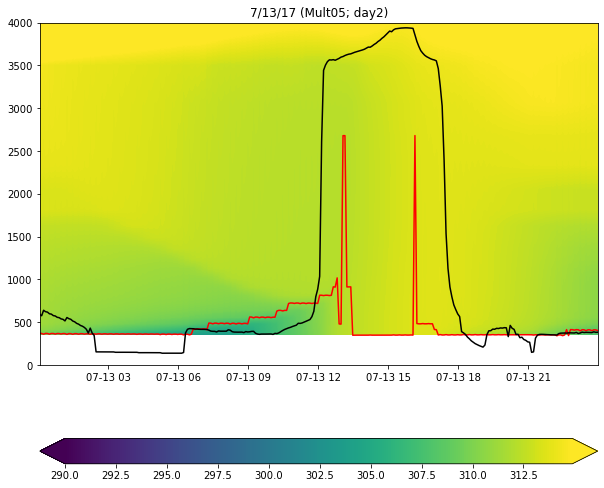

In [28]:
fig,axs = plt.subplots(1,1, figsize=(10,9) )

cplot = axs.contourf(htgDS_pertDay2_mult05_local.time.values, 
                     # htgDS_pertDay2_mult10_local.lev.values, 
                     zlevm05.mean(dim='time'),
                     np.squeeze(htgDS_pertDay2_mult05_local.theta.values).transpose(),
                     levels=np.arange(290,315,0.1),
                     cmap='viridis',extend='both'
                     )

# axs2 = axs.twinx()
axs.plot(htgDS_pertDay2_mult05_local.time.values,PBLdepth05,'r-')
axs.plot(htgDS_pertDay2_mult05_local.time.values, np.squeeze(htgDS_pertDay2_mult05_local.PBLH.values),'k-')

# axs.invert_yaxis()
axs.set_ylim([0,4000])
fig.colorbar(cplot, orientation='horizontal')
axs.set_title('7/13/17 (Mult05; day2)')


In [137]:
p0 = htgDS_pertDay2_mult10_local.P0.values[0]

plevm10 = htgDS_pertDay2_mult10_local['hyam']*p0 + htgDS_pertDay2_mult10_local['hybm']*htgDS_pertDay2_mult10_local['PS'].isel(lat=0,lon=0) # Mid level
plevm10.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm10      = plevm10
zlevm10_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm10)) # Units of [m] after multiplied 
zlevm10      = plevm10.copy(deep=True)
zlevm10[:,:] = zlevm10_vals


pvar10        = htgDS_pertDay2_mult10_local['Q'].isel(lat=0,lon=0)
pvar10['lev'] = zlevm10[0,:].values
dvardz10      = pvar10.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz10.loc[:,200:]   = 0.  # Restrict to a specific height region
dvardz10.loc[:,:3000.] = 0

nT         = np.shape(dvardz10)[0]
PBLdepth10 = np.full([nT], np.nan)

for iT in range(nT):
    iLevs  = np.where((zlevm10[iT,:]>=200) & (zlevm10[iT,:]<=4000))[0]
    maxLev = np.where(np.abs(dvardz10[iT,iLevs])==np.nanmax(np.abs(dvardz10[iT,iLevs])))[0]
    PBLdepth10[iT] = zlevm10[iT,iLevs[maxLev[0]]]



In [138]:
p0 = htgDS_pertDay2_mult05_local.P0.values[0]

plevm05 = htgDS_pertDay2_mult05_local['hyam']*p0 + htgDS_pertDay2_mult05_local['hybm']*htgDS_pertDay2_mult05_local['PS'].isel(lat=0,lon=0) # Mid level
plevm05.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm05      = plevm05
zlevm05_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm05)) # Units of [m] after multiplied 
zlevm05      = plevm05.copy(deep=True)
zlevm05[:,:] = zlevm05_vals


pvar05        = htgDS_pertDay2_mult05_local['Q'].isel(lat=0,lon=0)
pvar05['lev'] = zlevm05[0,:].values
dvardz05      = pvar05.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz05.loc[:,200:]   = 0.  # Restrict to a specific height region
dvardz05.loc[:,:3000.] = 0

nT         = np.shape(dvardz05)[0]
PBLdepth05 = np.full([nT], np.nan)

for iT in range(nT):
    iLevs  = np.where((zlevm05[iT,:]>=200) & (zlevm05[iT,:]<=4000))[0]
    maxLev = np.where(np.abs(dvardz05[iT,iLevs])==np.nanmax(np.abs(dvardz05[iT,iLevs])))[0]
    PBLdepth05[iT] = zlevm05[iT,iLevs[maxLev[0]]]



Text(0.5, 1.0, '7/13/17 (Mult10; day2)')

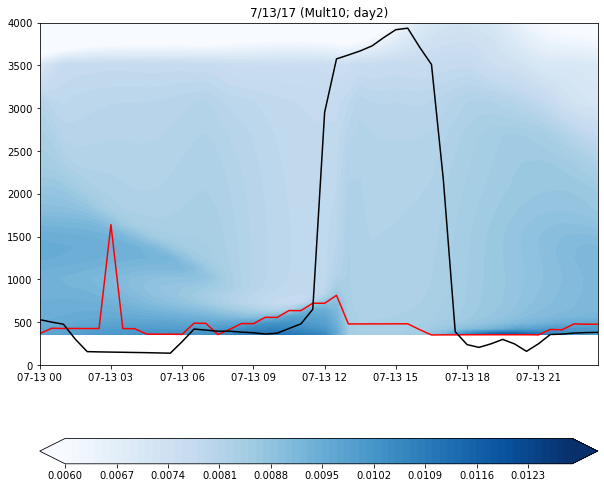

In [139]:
fig,axs = plt.subplots(1,1, figsize=(10,9) )

cplot = axs.contourf(htgDS_pertDay2_mult10_local.time.values, 
                     # htgDS_pertDay2_mult10_local.lev.values, 
                     zlevm10.mean(dim='time'),
                     np.squeeze(htgDS_pertDay2_mult10_local.Q.values).transpose(),
                     levels=np.arange(0.006,0.013,0.0001),
                     cmap='Blues',extend='both'
                     )

# axs2 = axs.twinx()
axs.plot(htgDS_pertDay2_mult10_local.time.values,PBLdepth10,'r-')
axs.plot(htgDS_pertDay2_mult10_local.time.values, np.squeeze(htgDS_pertDay2_mult10_local.PBLH.values),'k-')

# axs.invert_yaxis()
axs.set_ylim([0,4000])
fig.colorbar(cplot, orientation='horizontal')
axs.set_title('7/13/17 (Mult10; day2)')


Text(0.5, 1.0, '7/13/17 (Mult5; day2)')

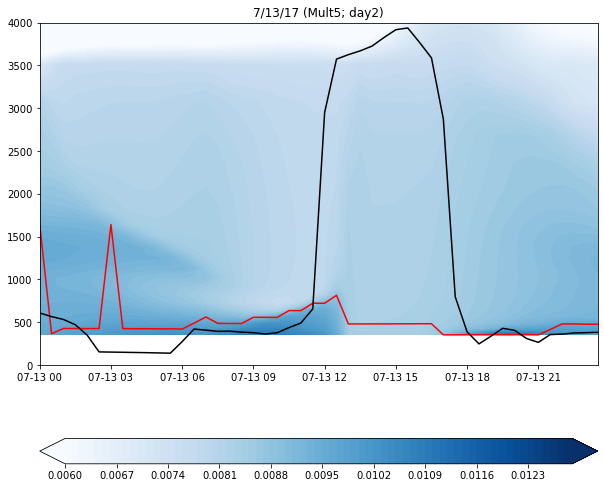

In [140]:
fig,axs = plt.subplots(1,1, figsize=(10,9) )

cplot = axs.contourf(htgDS_pertDay2_mult05_local.time.values, 
                     # htgDS_pertDay2_mult05_local.lev.values, 
                     zlevm05.mean(dim='time'),
                     np.squeeze(htgDS_pertDay2_mult05_local.Q.values).transpose(),
                     levels=np.arange(0.006,0.013,0.0001),
                     cmap='Blues',extend='both')

axs.plot(htgDS_pertDay2_mult05_local.time.values,PBLdepth05,'r-')
axs.plot(htgDS_pertDay2_mult05_local.time.values, np.squeeze(htgDS_pertDay2_mult05_local.PBLH.values),'k-')

# axs.invert_yaxis()
axs.set_ylim([0,4000])
fig.colorbar(cplot, orientation='horizontal')
axs.set_title('7/13/17 (Mult5; day2)')

In [141]:
p0 = htgDS_pertDay2_mult10_local.P0.values[0]

plevm10 = htgDS_pertDay2_mult10_local['hyam']*p0 + htgDS_pertDay2_mult10_local['hybm']*htgDS_pertDay2_mult10_local['PS'].isel(lat=0,lon=0) # Mid level
plevm10.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm10      = plevm10
zlevm10_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm10)) # Units of [m] after multiplied 
zlevm10      = plevm10.copy(deep=True)
zlevm10[:,:] = zlevm10_vals


pvar10        = htgDS_pertDay2_mult10_local['THETAL'].isel(lat=0,lon=0)
pvar10['lev'] = zlevm10[0,:].values
dvardz10      = pvar10.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz10.loc[:,200:]   = 0.  # Restrict to a specific height region
dvardz10.loc[:,:3000.] = 0

nT         = np.shape(dvardz10)[0]
PBLdepth10 = np.full([nT], np.nan)

for iT in range(nT):
    iLevs  = np.where((zlevm10[iT,:]>=200) & (zlevm10[iT,:]<=4000))[0]
    maxLev = np.where(np.abs(dvardz10[iT,iLevs])==np.nanmax(np.abs(dvardz10[iT,iLevs])))[0]
    PBLdepth10[iT] = zlevm10[iT,iLevs[maxLev[0]]]



In [142]:
p0 = htgDS_pertDay2_mult05_local.P0.values[0]

plevm05 = htgDS_pertDay2_mult05_local['hyam']*p0 + htgDS_pertDay2_mult05_local['hybm']*htgDS_pertDay2_mult05_local['PS'].isel(lat=0,lon=0) # Mid level
plevm05.attrs['units'] = "Pa"

# Height with standard atmosphere
zlevm05      = plevm05
zlevm05_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm05)) # Units of [m] after multiplied 
zlevm05      = plevm05.copy(deep=True)
zlevm05[:,:] = zlevm05_vals


pvar05        = htgDS_pertDay2_mult05_local['THETAL'].isel(lat=0,lon=0)
pvar05['lev'] = zlevm05[0,:].values
dvardz05      = pvar05.differentiate("lev") # Find field gradient wrt HEIGHT!

dvardz05.loc[:,200:]   = 0.  # Restrict to a specific height region
dvardz05.loc[:,:3000.] = 0

nT         = np.shape(dvardz05)[0]
PBLdepth05 = np.full([nT], np.nan)

for iT in range(nT):
    iLevs  = np.where((zlevm05[iT,:]>=200) & (zlevm05[iT,:]<=4000))[0]
    maxLev = np.where(np.abs(dvardz05[iT,iLevs])==np.nanmax(np.abs(dvardz05[iT,iLevs])))[0]
    PBLdepth05[iT] = zlevm05[iT,iLevs[maxLev[0]]]



Text(0.5, 1.0, '7/13/17 (Mult10; day2)')

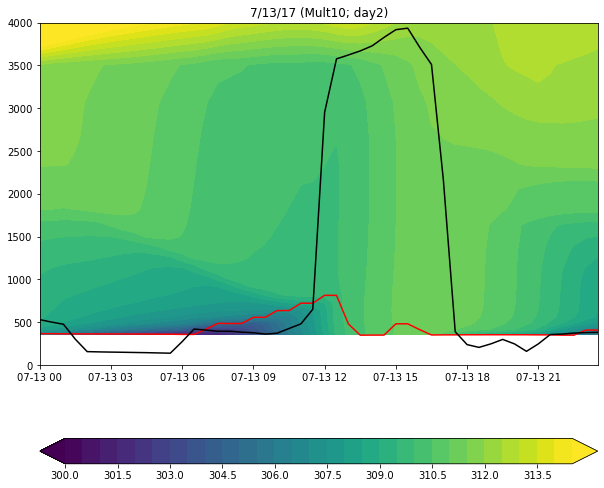

In [143]:
fig,axs = plt.subplots(1,1, figsize=(10,9) )

cplot = axs.contourf(htgDS_pertDay2_mult10_local.time.values, 
                     # htgDS_pertDay2_mult10_local.lev.values, 
                     zlevm10.mean(dim='time'),
                     np.squeeze(htgDS_pertDay2_mult10_local.THETAL.values).transpose(),
                     levels=np.arange(300,315,0.5),
                     cmap='viridis',extend='both'
                     )

axs.plot(htgDS_pertDay2_mult10_local.time.values,PBLdepth10,'r-')
axs.plot(htgDS_pertDay2_mult10_local.time.values,np.squeeze(htgDS_pertDay2_mult10_local.PBLH.values),'k-')

axs.set_ylim([0,4000])
fig.colorbar(cplot, orientation='horizontal')
axs.set_title('7/13/17 (Mult10; day2)')


Text(0.5, 1.0, '7/13/17 (Mult05; day2)')

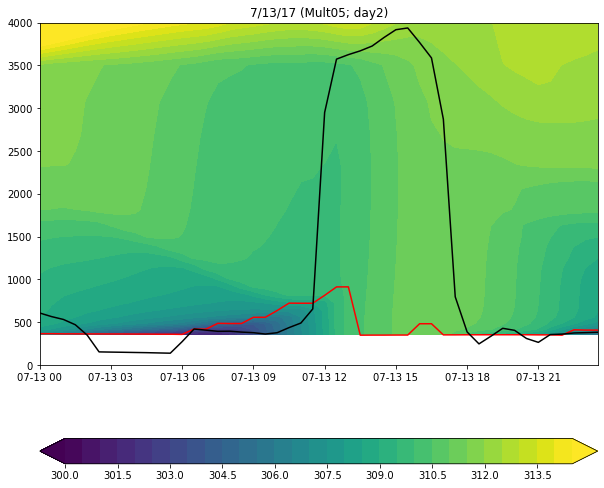

In [144]:
fig,axs = plt.subplots(1,1, figsize=(10,9) )

cplot = axs.contourf(htgDS_pertDay2_mult05_local.time.values, 
                     # htgDS_pertDay2_mult05_local.lev.values, 
                     zlevm05.mean(dim='time'),
                     np.squeeze(htgDS_pertDay2_mult05_local.THETAL.values).transpose(),
                     levels=np.arange(300,315,0.5),
                     cmap='viridis',extend='both'
                     )

axs.plot(htgDS_pertDay2_mult05_local.time.values,PBLdepth05,'r-')
axs.plot(htgDS_pertDay2_mult05_local.time.values,np.squeeze(htgDS_pertDay2_mult05_local.PBLH.values),'k-')

axs.set_ylim([0,4000])
fig.colorbar(cplot, orientation='horizontal')
axs.set_title('7/13/17 (Mult05; day2)')
